In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

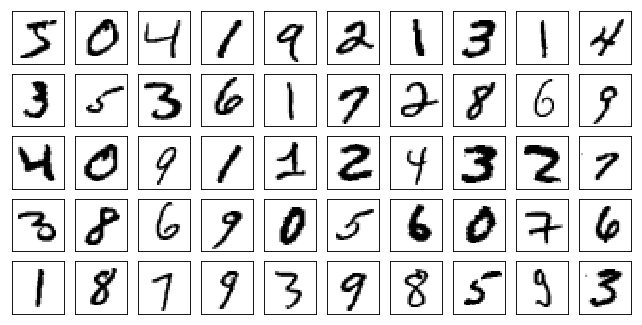

In [3]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [8]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [10]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.321211 drop: 2.366359 plain: 2.315452
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 1.983631 drop: 2.143769 plain: 2.079109
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.617757 drop: 1.699987 plain: 1.482413
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 1.223414 drop: 1.012117 plain: 0.870405
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 1.026440 drop: 0.779003 plain: 0.677134
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.806642 drop: 0.594043 plain: 0.545427
Test set:
bn: Loss: 0.8310	Accuracy: 8976.0/10000 (90%)
drop: Loss: 0.6549	Accuracy: 8473.0/10000 (85%)
plain: Loss: 0.5985	Accuracy: 8621.0/10000 (86%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.945210 drop: 0.842307 plain: 0.813063
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.583218 drop: 0.421145 plain: 0.348294
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.626592 drop: 0.534753 plain: 0.502547
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.515316 drop: 0.464888 plain: 0.45

Train Epoch: 13 [30000/50000 (60%)]	Losses bn: 0.087020 drop: 0.107918 plain: 0.087848
Train Epoch: 13 [40000/50000 (80%)]	Losses bn: 0.063241 drop: 0.093782 plain: 0.092025
Train Epoch: 13 [50000/50000 (100%)]	Losses bn: 0.111502 drop: 0.133983 plain: 0.111518
Test set:
bn: Loss: 0.0620	Accuracy: 9826.0/10000 (98%)
drop: Loss: 0.0763	Accuracy: 9794.0/10000 (98%)
plain: Loss: 0.0821	Accuracy: 9786.0/10000 (98%)

Train Epoch: 14 [0/50000 (0%)]	Losses bn: 0.043944 drop: 0.056376 plain: 0.074980
Train Epoch: 14 [10000/50000 (20%)]	Losses bn: 0.111450 drop: 0.115631 plain: 0.122007
Train Epoch: 14 [20000/50000 (40%)]	Losses bn: 0.036749 drop: 0.053451 plain: 0.058533
Train Epoch: 14 [30000/50000 (60%)]	Losses bn: 0.092588 drop: 0.131743 plain: 0.143191
Train Epoch: 14 [40000/50000 (80%)]	Losses bn: 0.163556 drop: 0.237785 plain: 0.243132
Train Epoch: 14 [50000/50000 (100%)]	Losses bn: 0.062185 drop: 0.132587 plain: 0.154689
Test set:
bn: Loss: 0.0598	Accuracy: 9839.0/10000 (98%)
drop: Loss

Train Epoch: 25 [50000/50000 (100%)]	Losses bn: 0.006077 drop: 0.014395 plain: 0.016973
Test set:
bn: Loss: 0.0457	Accuracy: 9867.0/10000 (99%)
drop: Loss: 0.0558	Accuracy: 9834.0/10000 (98%)
plain: Loss: 0.0577	Accuracy: 9841.0/10000 (98%)

Train Epoch: 26 [0/50000 (0%)]	Losses bn: 0.028269 drop: 0.062989 plain: 0.057384
Train Epoch: 26 [10000/50000 (20%)]	Losses bn: 0.011680 drop: 0.017395 plain: 0.017992
Train Epoch: 26 [20000/50000 (40%)]	Losses bn: 0.011372 drop: 0.008431 plain: 0.010662
Train Epoch: 26 [30000/50000 (60%)]	Losses bn: 0.054524 drop: 0.063850 plain: 0.089488
Train Epoch: 26 [40000/50000 (80%)]	Losses bn: 0.013299 drop: 0.029598 plain: 0.026037
Train Epoch: 26 [50000/50000 (100%)]	Losses bn: 0.023931 drop: 0.030393 plain: 0.033021
Test set:
bn: Loss: 0.0461	Accuracy: 9865.0/10000 (99%)
drop: Loss: 0.0556	Accuracy: 9837.0/10000 (98%)
plain: Loss: 0.0566	Accuracy: 9840.0/10000 (98%)

Train Epoch: 27 [0/50000 (0%)]	Losses bn: 0.033743 drop: 0.064461 plain: 0.041079
Trai

Train Epoch: 38 [10000/50000 (20%)]	Losses bn: 0.011478 drop: 0.029399 plain: 0.026290
Train Epoch: 38 [20000/50000 (40%)]	Losses bn: 0.026577 drop: 0.025469 plain: 0.036301
Train Epoch: 38 [30000/50000 (60%)]	Losses bn: 0.009138 drop: 0.014397 plain: 0.006625
Train Epoch: 38 [40000/50000 (80%)]	Losses bn: 0.054361 drop: 0.082528 plain: 0.104217
Train Epoch: 38 [50000/50000 (100%)]	Losses bn: 0.018166 drop: 0.018464 plain: 0.020306
Test set:
bn: Loss: 0.0404	Accuracy: 9881.0/10000 (99%)
drop: Loss: 0.0497	Accuracy: 9849.0/10000 (98%)
plain: Loss: 0.0500	Accuracy: 9856.0/10000 (99%)

Train Epoch: 39 [0/50000 (0%)]	Losses bn: 0.081513 drop: 0.174758 plain: 0.159801
Train Epoch: 39 [10000/50000 (20%)]	Losses bn: 0.015375 drop: 0.035930 plain: 0.035884
Train Epoch: 39 [20000/50000 (40%)]	Losses bn: 0.026939 drop: 0.027451 plain: 0.030880
Train Epoch: 39 [30000/50000 (60%)]	Losses bn: 0.020674 drop: 0.042843 plain: 0.052811
Train Epoch: 39 [40000/50000 (80%)]	Losses bn: 0.008618 drop: 0.021

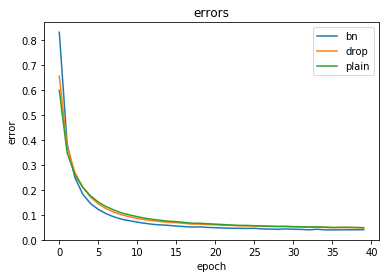

In [11]:
plot_graphs(test_log, 'loss')

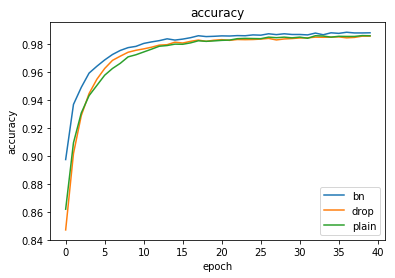

In [12]:
plot_graphs(test_log, 'accuracy')

In [13]:
torch.save(models['bn'], './model_classifier_conv')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Оптимизация изображений

In [10]:
model = torch.load('./model_classifier_conv')

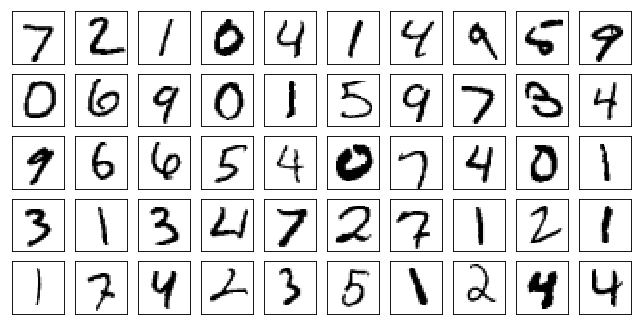

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [11]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

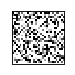

In [41]:
data, _ = next(iter(test_loader))
#img = torch.ones((50, 784))
img = torch.randn((784)).view(-1, 1, 28, 28)
to_plot = img.clamp(0, 1).data.numpy()
plot_mnist(to_plot, (5, 10))


In [42]:
from torch.autograd import Variable

def generate_image(img, cl):
    
    gen_img_par = Variable(img, requires_grad=True)    
    target = torch.zeros((10)) 
    target[cl] = 1
    target = target.view(1, 10)
    
    loss_stats = []    
    gen_optim = optim.Adam([gen_img_par], lr=1, weight_decay=0.1)

    for i in range(1, 3000001):  
             
        out = torch.exp(model.forward(gen_img_par))
                 
        gen_optim.zero_grad()
        loss = F.mse_loss(out, target)    
        loss.backward()          
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={} prediction={}".format(i,loss, out.argmax()))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #1print("PRED=", out.argmax())
            print("OUT=", out)
            #print("TR=", target)
                        
            if len(loss_stats) > 1000:    
                if ls > loss_stats[-2] and ls > loss_stats[-3] and ls > loss_stats[-4] and ls > loss_stats[-5]:
                    print ("Loss is rising .. stop")
                    break

        if i % 50000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 1))
                        
    return gen_img_par    

Iteration 5000: loss=0.12192873656749725 prediction=8
OUT= tensor([[ 0.0225,  0.0008,  0.0811,  0.0056,  0.0000,  0.0001,  0.0001,
          0.0006,  0.4223,  0.1881]])
Iteration 10000: loss=0.11941418796777725 prediction=8
OUT= tensor([[ 0.0398,  0.0011,  0.0825,  0.0030,  0.0000,  0.0001,  0.0004,
          0.0006,  0.4155,  0.1236]])
Iteration 15000: loss=0.12326630204916 prediction=8
OUT= tensor([[ 0.0029,  0.0006,  0.0823,  0.0134,  0.0001,  0.0001,  0.0002,
          0.0022,  0.4763,  0.0059]])
Iteration 20000: loss=0.12474904954433441 prediction=8
OUT= tensor([[ 0.0580,  0.0010,  0.0648,  0.0029,  0.0000,  0.0002,  0.0001,
          0.0007,  0.4806,  0.1045]])
Iteration 25000: loss=27.17034912109375 prediction=7
OUT= tensor([[ 1.0285e-05,  2.8486e+00,  5.7028e+00,  1.0934e-01,  1.1484e+00,
          7.2070e+00,  1.4097e-05,  1.3509e+01,  3.6256e-08,  1.0467e-06]])
Iteration 30000: loss=0.13157792389392853 prediction=8
OUT= tensor([[ 0.0845,  0.0006,  0.0132,  0.0010,  0.0000,  0

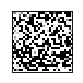

Iteration 55000: loss=0.12425495684146881 prediction=8
OUT= tensor([[ 0.0488,  0.0015,  0.0357,  0.0020,  0.0000,  0.0002,  0.0001,
          0.0009,  0.4603,  0.1734]])
Iteration 60000: loss=0.2284095585346222 prediction=7
OUT= tensor([[ 2.3358e-03,  8.4250e-02,  7.3071e-01,  6.2939e-02,  5.6712e-06,
          7.3009e-02,  9.5906e-05,  9.4988e-01,  5.4208e-06,  4.8414e-04]])
Iteration 65000: loss=0.13389188051223755 prediction=8
OUT= tensor([[ 0.0014,  0.0011,  0.1600,  0.1181,  0.0000,  0.0001,  0.0001,
          0.0022,  0.5489,  0.0169]])
Iteration 70000: loss=0.12388934195041656 prediction=8
OUT= tensor([[ 0.0635,  0.0008,  0.1050,  0.0006,  0.0001,  0.0002,  0.0003,
          0.0005,  0.4539,  0.1394]])
Iteration 75000: loss=0.12773703038692474 prediction=8
OUT= tensor([[ 0.0276,  0.0011,  0.0101,  0.0151,  0.0000,  0.0002,  0.0000,
          0.0009,  0.5098,  0.1365]])
Iteration 80000: loss=0.12681931257247925 prediction=8
OUT= tensor([[ 0.0734,  0.0008,  0.0763,  0.0009,  0.000

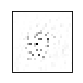

Iteration 105000: loss=0.49841389060020447 prediction=7
OUT= tensor([[ 3.5191e-07,  3.1801e-02,  8.6598e-01,  2.0194e-01,  2.7774e-01,
          1.2360e+00,  9.1465e-04,  1.2850e+00,  6.3933e-08,  1.3279e-06]])
Iteration 110000: loss=0.1286361813545227 prediction=8
OUT= tensor([[ 0.0787,  0.0006,  0.1090,  0.0021,  0.0000,  0.0001,  0.0003,
          0.0006,  0.5109,  0.0918]])
Iteration 115000: loss=0.7266401052474976 prediction=5
OUT= tensor([[ 4.7760e-07,  8.2692e-01,  1.0771e+00,  5.2254e-02,  7.4116e-02,
          2.1554e+00,  1.0253e-03,  1.1926e+00,  2.1721e-06,  1.8318e-06]])
Iteration 120000: loss=0.12345977872610092 prediction=8
OUT= tensor([[ 0.1564,  0.0014,  0.0829,  0.0011,  0.0000,  0.0002,  0.0001,
          0.0015,  0.4492,  0.0657]])
Iteration 125000: loss=0.1219194307923317 prediction=8
OUT= tensor([[ 0.0664,  0.0012,  0.0656,  0.0016,  0.0000,  0.0002,  0.0001,
          0.0007,  0.4468,  0.1155]])
Iteration 130000: loss=0.12513600289821625 prediction=8
OUT= tensor(

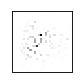

Iteration 155000: loss=0.12723375856876373 prediction=8
OUT= tensor([[ 0.0136,  0.0011,  0.0841,  0.0076,  0.0000,  0.0001,  0.0000,
          0.0015,  0.5124,  0.0683]])
Iteration 160000: loss=0.12312568724155426 prediction=8
OUT= tensor([[ 0.0256,  0.0016,  0.0387,  0.0047,  0.0000,  0.0002,  0.0001,
          0.0012,  0.4568,  0.1534]])
Iteration 165000: loss=0.13121546804904938 prediction=2
OUT= tensor([[ 0.0000,  0.0073,  0.4816,  0.0174,  0.0012,  0.2939,  0.0000,
          0.0906,  0.0000,  0.0000]])
Iteration 170000: loss=0.12689855694770813 prediction=8
OUT= tensor([[ 0.0840,  0.0014,  0.0301,  0.0011,  0.0000,  0.0003,  0.0000,
          0.0008,  0.4801,  0.1828]])
Iteration 175000: loss=11.72265338897705 prediction=5
OUT= tensor([[ 1.1600e-06,  4.3385e-01,  4.0611e-01,  2.6706e-01,  3.6432e-01,
          7.9511e+00,  1.5810e-04,  7.3019e+00,  4.2964e-08,  3.6225e-06]])
Iteration 180000: loss=0.12121559679508209 prediction=8
OUT= tensor([[ 0.0081,  0.0006,  0.0493,  0.0239,  

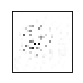

Iteration 205000: loss=0.12266366183757782 prediction=8
OUT= tensor([[ 0.0009,  0.0002,  0.0995,  0.0004,  0.0027,  0.0003,  0.0030,
          0.0001,  0.4659,  0.0029]])
Iteration 210000: loss=0.12410775572061539 prediction=8
OUT= tensor([[ 0.0489,  0.0007,  0.0728,  0.0031,  0.0000,  0.0001,  0.0001,
          0.0005,  0.4752,  0.0945]])
Iteration 215000: loss=0.1251535266637802 prediction=8
OUT= tensor([[ 0.0159,  0.0007,  0.0403,  0.0030,  0.0000,  0.0004,  0.0003,
          0.0013,  0.4955,  0.0739]])
Iteration 220000: loss=0.12881651520729065 prediction=8
OUT= tensor([[ 0.0585,  0.0022,  0.0733,  0.0032,  0.0000,  0.0001,  0.0001,
          0.0009,  0.5169,  0.1284]])
Iteration 225000: loss=9.564004898071289 prediction=7
OUT= tensor([[ 1.2286e-06,  6.8383e-02,  1.3082e+00,  1.5346e+00,  1.9403e-01,
          6.6888e+00,  2.9721e-05,  6.7770e+00,  1.7883e-07,  1.1174e-05]])
Iteration 230000: loss=0.11974100023508072 prediction=8
OUT= tensor([[ 0.0148,  0.0002,  0.0533,  0.0003,  0

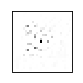

Iteration 255000: loss=0.12349454313516617 prediction=8
OUT= tensor([[ 0.0767,  0.0014,  0.1436,  0.0005,  0.0000,  0.0004,  0.0008,
          0.0007,  0.4502,  0.0925]])
Iteration 260000: loss=0.13005834817886353 prediction=8
OUT= tensor([[ 0.1361,  0.0014,  0.0158,  0.0007,  0.0000,  0.0004,  0.0000,
          0.0008,  0.4979,  0.1916]])
Iteration 265000: loss=0.12615005671977997 prediction=8
OUT= tensor([[ 0.0470,  0.0006,  0.1592,  0.0013,  0.0000,  0.0002,  0.0003,
          0.0006,  0.4800,  0.0692]])
Iteration 270000: loss=0.1252007633447647 prediction=8
OUT= tensor([[ 0.0087,  0.0002,  0.0278,  0.0003,  0.0003,  0.0004,  0.0001,
          0.0007,  0.5005,  0.0312]])
Iteration 275000: loss=0.1296028047800064 prediction=8
OUT= tensor([[ 0.0948,  0.0011,  0.1430,  0.0011,  0.0000,  0.0001,  0.0002,
          0.0008,  0.5111,  0.0875]])
Iteration 280000: loss=0.12384893000125885 prediction=8
OUT= tensor([[ 0.1171,  0.0011,  0.1035,  0.0008,  0.0000,  0.0003,  0.0002,
          0.00

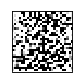

Iteration 305000: loss=0.12414088100194931 prediction=8
OUT= tensor([[ 0.0249,  0.0006,  0.0573,  0.0066,  0.0000,  0.0001,  0.0001,
          0.0004,  0.4547,  0.1785]])
Iteration 310000: loss=0.13031019270420074 prediction=8
OUT= tensor([[ 0.0234,  0.0008,  0.0634,  0.0074,  0.0000,  0.0001,  0.0001,
          0.0005,  0.5219,  0.1664]])
Iteration 315000: loss=0.13203157484531403 prediction=8
OUT= tensor([[ 0.0566,  0.0005,  0.0356,  0.0034,  0.0000,  0.0001,  0.0000,
          0.0006,  0.5240,  0.2052]])
Iteration 320000: loss=2.212118625640869 prediction=2
OUT= tensor([[ 7.1953e-06,  1.4493e+00,  3.0523e+00,  7.1401e-02,  5.6544e-01,
          2.6435e+00,  6.4853e-05,  2.3000e+00,  8.8497e-08,  4.9955e-07]])
Iteration 325000: loss=0.12551197409629822 prediction=8
OUT= tensor([[ 0.0292,  0.0016,  0.1183,  0.0181,  0.0000,  0.0001,  0.0001,
          0.0012,  0.4928,  0.0181]])
Iteration 330000: loss=0.12704259157180786 prediction=8
OUT= tensor([[ 2.5651e-02,  1.6918e-03,  1.1588e-01

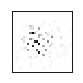

Iteration 355000: loss=0.12658348679542542 prediction=8
OUT= tensor([[ 0.0858,  0.0007,  0.1504,  0.0007,  0.0000,  0.0001,  0.0004,
          0.0003,  0.4779,  0.0944]])
Iteration 360000: loss=0.1234189048409462 prediction=8
OUT= tensor([[ 0.0240,  0.0010,  0.0696,  0.0040,  0.0000,  0.0001,  0.0001,
          0.0011,  0.4676,  0.1096]])
Iteration 365000: loss=3.9987194538116455 prediction=5
OUT= tensor([[ 1.9002e-05,  3.1188e-01,  3.5436e+00,  1.6442e-01,  3.1950e-01,
          4.7688e+00,  6.4674e-05,  2.0215e+00,  1.5691e-07,  2.3234e-07]])
Iteration 370000: loss=0.1276392787694931 prediction=8
OUT= tensor([[ 0.0377,  0.0002,  0.1028,  0.0003,  0.0001,  0.0001,  0.0001,
          0.0001,  0.5060,  0.0933]])
Iteration 375000: loss=0.1281164288520813 prediction=8
OUT= tensor([[ 0.0563,  0.0008,  0.0617,  0.0013,  0.0000,  0.0001,  0.0001,
          0.0006,  0.5085,  0.1307]])
Iteration 380000: loss=0.10289473831653595 prediction=2
OUT= tensor([[ 2.5018e-07,  4.1177e-03,  1.4064e-01, 

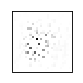

Iteration 405000: loss=0.10382004827260971 prediction=5
OUT= tensor([[ 0.0001,  0.0000,  0.0192,  0.0000,  0.0118,  0.1926,  0.0006,
          0.0003,  0.0257,  0.0000]])
Iteration 410000: loss=0.13057130575180054 prediction=8
OUT= tensor([[ 0.1222,  0.0007,  0.0718,  0.0004,  0.0000,  0.0003,  0.0002,
          0.0004,  0.5078,  0.1708]])
Iteration 415000: loss=0.12450055778026581 prediction=8
OUT= tensor([[ 0.0477,  0.0022,  0.1661,  0.0018,  0.0000,  0.0001,  0.0002,
          0.0011,  0.4646,  0.0602]])
Iteration 420000: loss=0.12257124483585358 prediction=8
OUT= tensor([[ 0.0233,  0.0001,  0.1187,  0.0004,  0.0004,  0.0001,  0.0000,
          0.0002,  0.4456,  0.1128]])
Iteration 425000: loss=0.12516170740127563 prediction=8
OUT= tensor([[ 0.0455,  0.0016,  0.0207,  0.0025,  0.0000,  0.0002,  0.0000,
          0.0009,  0.4591,  0.2039]])
Iteration 430000: loss=0.12208479642868042 prediction=8
OUT= tensor([[ 0.0651,  0.0005,  0.1460,  0.0013,  0.0000,  0.0002,  0.0001,
          0.

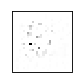

Iteration 455000: loss=0.1289617419242859 prediction=7
OUT= tensor([[ 4.9424e-07,  9.8723e-04,  1.7135e-01,  3.0236e-01,  4.1383e-02,
          2.5128e-01,  3.3738e-04,  3.2551e-01,  1.4782e-05,  4.3369e-07]])
Iteration 460000: loss=0.1346147209405899 prediction=8
OUT= tensor([[ 0.0013,  0.0012,  0.0641,  0.1952,  0.0000,  0.0001,  0.0002,
          0.0030,  0.5529,  0.0243]])
Iteration 465000: loss=0.12759754061698914 prediction=8
OUT= tensor([[ 0.0309,  0.0013,  0.1696,  0.0046,  0.0000,  0.0001,  0.0001,
          0.0026,  0.4982,  0.0236]])
Iteration 470000: loss=0.11013256013393402 prediction=5
OUT= tensor([[ 2.2405e-06,  7.1570e-05,  1.4398e-01,  1.2386e-03,  2.5560e-03,
          2.8411e-01,  1.8747e-05,  5.2455e-04,  2.8043e-03,  1.8077e-04]])
Iteration 475000: loss=0.12270759046077728 prediction=8
OUT= tensor([[ 0.0786,  0.0014,  0.0531,  0.0019,  0.0000,  0.0002,  0.0001,
          0.0009,  0.4465,  0.1470]])
Iteration 480000: loss=0.12729699909687042 prediction=8
OUT= tensor

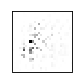

Iteration 505000: loss=2.5891168117523193 prediction=2
OUT= tensor([[ 4.0339e-06,  1.3711e+00,  4.0005e+00,  2.3109e-01,  1.5494e-01,
          2.4857e+00,  3.6537e-05,  1.8691e+00,  1.2507e-08,  2.3778e-06]])
Iteration 510000: loss=0.12439978122711182 prediction=8
OUT= tensor([[ 0.0490,  0.0008,  0.0765,  0.0012,  0.0001,  0.0002,  0.0001,
          0.0003,  0.4494,  0.1878]])
Iteration 515000: loss=53.000633239746094 prediction=7
OUT= tensor([[ 2.5760e-06,  5.4889e+00,  1.3239e+01,  2.6791e-01,  9.4930e-01,
          9.4653e+00,  1.7896e-05,  1.5621e+01,  1.3708e-08,  4.5574e-07]])
Iteration 520000: loss=0.12253429740667343 prediction=8
OUT= tensor([[ 0.0018,  0.0024,  0.0219,  0.0945,  0.0000,  0.0002,  0.0001,
          0.0010,  0.4565,  0.1112]])
Iteration 525000: loss=0.1180967316031456 prediction=8
OUT= tensor([[ 0.0074,  0.0012,  0.0264,  0.0111,  0.0001,  0.0002,  0.0001,
          0.0019,  0.4105,  0.1184]])
Iteration 530000: loss=0.1240154355764389 prediction=8
OUT= tensor([

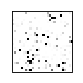

Iteration 555000: loss=0.12210218608379364 prediction=8
OUT= tensor([[ 0.1418,  0.0006,  0.0873,  0.0006,  0.0000,  0.0003,  0.0005,
          0.0004,  0.4377,  0.0532]])
Iteration 560000: loss=0.12691766023635864 prediction=8
OUT= tensor([[ 0.1266,  0.0005,  0.1411,  0.0003,  0.0000,  0.0003,  0.0011,
          0.0003,  0.4748,  0.0940]])
Iteration 565000: loss=0.10209403187036514 prediction=8
OUT= tensor([[ 3.6964e-06,  4.8417e-06,  2.6886e-02,  3.0156e-04,  2.6997e-03,
          1.0582e-02,  1.9746e-06,  8.8866e-05,  1.4149e-01,  9.4228e-03]])
Iteration 570000: loss=0.12234644591808319 prediction=8
OUT= tensor([[ 0.0223,  0.0013,  0.0926,  0.0041,  0.0000,  0.0001,  0.0000,
          0.0010,  0.4492,  0.1230]])
Iteration 575000: loss=0.12427575886249542 prediction=8
OUT= tensor([[ 0.1221,  0.0011,  0.0554,  0.0005,  0.0000,  0.0003,  0.0001,
          0.0006,  0.4647,  0.1048]])
Iteration 580000: loss=0.12420229613780975 prediction=8
OUT= tensor([[ 0.0642,  0.0007,  0.0859,  0.0003,

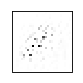

Iteration 605000: loss=0.7228497266769409 prediction=5
OUT= tensor([[ 6.0416e-06,  1.0921e+00,  1.8249e-01,  6.3547e-02,  1.1179e+00,
          2.3490e+00,  6.3671e-05,  6.4439e-01,  7.4612e-08,  1.6243e-05]])
Iteration 610000: loss=0.12128432095050812 prediction=8
OUT= tensor([[ 0.0630,  0.0009,  0.0681,  0.0014,  0.0000,  0.0006,  0.0001,
          0.0002,  0.4343,  0.1323]])
Iteration 615000: loss=0.12015986442565918 prediction=8
OUT= tensor([[ 0.0746,  0.0011,  0.0527,  0.0017,  0.0001,  0.0002,  0.0001,
          0.0006,  0.4016,  0.1848]])
Iteration 620000: loss=0.121688112616539 prediction=8
OUT= tensor([[ 3.3366e-02,  1.0367e-03,  8.4865e-02,  8.5078e-03,  9.6495e-06,
          9.7124e-05,  1.0587e-04,  6.9286e-04,  4.5491e-01,  6.0166e-02]])
Iteration 625000: loss=0.1451992392539978 prediction=5
OUT= tensor([[ 2.9198e-06,  1.2799e-03,  4.0038e-01,  3.9994e-04,  1.4172e-01,
          5.2358e-01,  7.2405e-04,  2.7342e-04,  4.9591e-03,  1.7339e-06]])
Iteration 630000: loss=0.1230

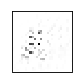

Iteration 655000: loss=0.12300354242324829 prediction=8
OUT= tensor([[ 0.0733,  0.0017,  0.0656,  0.0023,  0.0000,  0.0001,  0.0001,
          0.0005,  0.4591,  0.1143]])
Iteration 660000: loss=0.12536939978599548 prediction=8
OUT= tensor([[ 0.0184,  0.0002,  0.1533,  0.0013,  0.0001,  0.0002,  0.0002,
          0.0002,  0.4775,  0.0473]])
Iteration 665000: loss=0.12528584897518158 prediction=8
OUT= tensor([[ 0.0944,  0.0002,  0.0737,  0.0015,  0.0000,  0.0002,  0.0001,
          0.0004,  0.4727,  0.1243]])
Iteration 670000: loss=0.1361231654882431 prediction=2
OUT= tensor([[ 3.6689e-04,  1.3847e-01,  6.2835e-01,  5.5692e-04,  3.8360e-02,
          4.5269e-01,  4.8108e-04,  1.3332e-01,  9.7023e-06,  6.3833e-07]])
Iteration 675000: loss=0.12688937783241272 prediction=8
OUT= tensor([[ 0.1002,  0.0015,  0.2134,  0.0015,  0.0000,  0.0001,  0.0001,
          0.0016,  0.4626,  0.0481]])
Iteration 680000: loss=0.12292609363794327 prediction=8
OUT= tensor([[ 0.0721,  0.0012,  0.0776,  0.0011, 

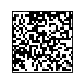

Iteration 705000: loss=0.10094455629587173 prediction=4
OUT= tensor([[ 3.0660e-08,  2.5565e-02,  2.9784e-02,  1.3464e-02,  2.1203e-01,
          5.7427e-02,  1.8639e-04,  1.0295e-01,  8.6403e-05,  3.4112e-06]])
Iteration 710000: loss=0.12722091376781464 prediction=8
OUT= tensor([[ 0.0510,  0.0005,  0.0940,  0.0045,  0.0000,  0.0000,  0.0001,
          0.0008,  0.5045,  0.0846]])
Iteration 715000: loss=0.13499026000499725 prediction=8
OUT= tensor([[ 0.0003,  0.0002,  0.1547,  0.0008,  0.0089,  0.0001,  0.0001,
          0.0001,  0.5711,  0.0063]])
Iteration 720000: loss=0.10793907940387726 prediction=2
OUT= tensor([[ 5.6182e-07,  4.0766e-04,  2.8177e-01,  2.3224e-02,  9.8459e-04,
          1.4098e-02,  3.5898e-04,  6.4651e-03,  5.4933e-03,  2.4407e-06]])
Iteration 725000: loss=0.12168500572443008 prediction=7
OUT= tensor([[ 6.3031e-07,  6.1821e-02,  2.9941e-01,  1.5729e-02,  1.0066e-02,
          1.2960e-01,  7.4709e-06,  4.7945e-01,  9.7612e-07,  7.8278e-05]])


KeyboardInterrupt: 

In [43]:
new_image_randn = generate_image(img, 1)